In [44]:
# standard libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import warnings
warnings.simplefilter('ignore')
import string
from string import digits
import gc
import math
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y')

# Visualisation
import plotly.express as px
from matplotlib import pyplot as plt

# keras libraries
import tensorflow as tf
from tensorflow import keras as k
from tqdm.keras import TqdmCallback

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn import model_selection

In [45]:

import sys
sys.path.insert(0, r"C:\\Users\\ACER\\anaconda3\\python.exe")

### Load Data

In [46]:
# load data
file = 'D:/Download-CC/test/gold.csv'
df = pd.read_csv(file, parse_dates=['Date'], date_parser=dateparse)

# drop NULLs
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# view
print(f"Found {df.shape[0]} records")

Found 2508 records


# Opt 1 - Single LSTM Layer

In [47]:
# creating a seperate df with Date column indexed
df1 = df.set_index('Date')
df1

,Close/Last,Volume,Open,High,Low
Date,,,,,
2022-10-28,1648.3,186519.0,1667.2,1670.9,1640.7
2022-10-27,1668.8,180599.0,1668.8,1674.8,1658.5
2022-10-26,1669.2,183453.0,1657.7,1679.4,1653.8
2022-10-25,1658.0,178706.0,1654.5,1666.8,1641.2
2022-10-24,1654.1,167448.0,1662.9,1675.5,1648.0
...,...,...,...,...,...
2012-11-06,1715.0,163585.0,1685.4,1720.9,1683.5
2012-11-05,1683.2,109647.0,1676.7,1686.2,1672.5
2012-11-02,1675.2,205777.0,1715.6,1717.2,1674.8


### Feature Engineering & Data Prep

In [48]:
# define features & target
features = ['Volume','Open','High','Low']
X = df1[features]   # features
y = df1[['Close/Last']]  # target

In [51]:
# instantiate MinMax Scaler function
mms = preprocessing.MinMaxScaler()

# applying the scaler function to features
X = mms.fit_transform(X)
y = mms.fit_transform(y)

In [52]:
# splitting to Training set and Test set
tss = model_selection.TimeSeriesSplit()

for train_index, test_index in tss.split(X):
  X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = y[:len(train_index)], y[len(train_index): (len(train_index)+len(test_index))]

In [53]:
# data prep for LSTM 
''' the training/test data needs to be converted into a format that LSTM can interpret i.e. in 3D matrix'''
# convert to array
trainX = np.array(X_train)
testX = np.array(X_test)

# reshape
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [54]:
# training data shape
print('Number of rows and columns in training : ', X_train.shape)
print('Number of rows and columns in test : ', X_test.shape)

Number of rows and columns in training :  (2090, 1, 4)
Number of rows and columns in test :  (418, 1, 4)


### Build Model

In [69]:
# build the model architecture
model = k.models.Sequential()

# add input layer (first LSTM layer)
model.add(k.layers.LSTM(units=32
                        ,return_sequences=False
                        ,input_shape=(1, trainX.shape[1])
                        ,activation='tanh'))

# add drop out (to prevent overfitting)
model.add(k.layers.Dropout(0.5))

# add output layer
model.add(k.layers.Dense(units=1, name='Output_Layer'))

# compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])    

# summary
# model.summary()

In [72]:
# plot model architecture
tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Train, Evaluate & Predict Model

In [37]:
# model fit params
epoch = 150

# clear session (for re-running/training)
gc.collect()
k.backend.clear_session()

# fit model
hist = model.fit(X_train
                 ,y_train
                 ,validation_data= (X_test, y_test)
                 ,epochs=epoch
                 ,verbose=0
                ,callbacks=[TqdmCallback(verbose=0)]
                , batch_size=8
                )

100%|██████████| 150/150 [01:29<00:00,  1.67epoch/s, loss=0.0023, mse=0.0023, val_loss=8.87e-5, val_mse=8.87e-5]    


In [38]:
# view loss value
loss = '{:.2e}'.format(hist.history['loss'][-1])
print(f"Our model's loss value dropped to {loss} over {epoch}")

Our model's loss value dropped to 2.30e-03 over 150


In [39]:
# prediction
y_pred = model.predict(X_test)

14/14 [==============================] - 0s 1ms/step


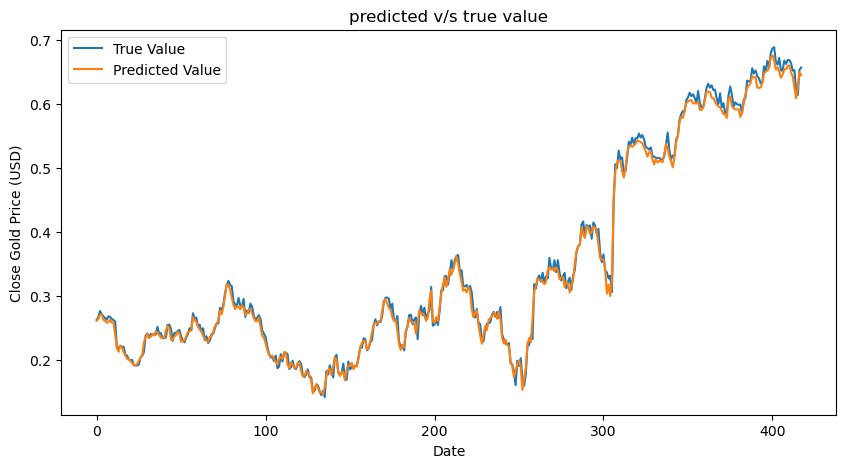

In [40]:
# comparing predicted v/s true value'
plt.figure(figsize=(10,5))
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='Predicted Value')
plt.title("predicted v/s true value")
plt.xlabel('Date')
plt.ylabel('Close Gold Price (USD)')
plt.legend()
plt.show()

**As, we can observe with 150 epochs the model's predicted value is quite close (even similar at times) to the true value.**

# Opt 2 - Multiple LSTM Layer

In [41]:
# setting Date column as index
df2 = df.set_index('Date')

In [42]:
# dataframe with only the Close/Last 
data_target = df2.filter(['Close/Last'])

# sort the list (by index)
data_target.sort_index(ascending=False, inplace=True)

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = math.ceil(len(target)* 0.85) # training set has 80% of the data
print(f"Training data length is {training_data_len}")

# Normalizing data before model fitting using MinMaxScaler
training_scaled_data = mms.fit_transform(target)

Training data length is 2132


In [56]:
# Create a training dataset containing the last n day closing price values we want to use to estimate the n+1 closing price value.
train_data = training_scaled_data[0:training_data_len  , : ]

n = 1095 # ~ last 3 years data
X_train = []
y_train = []
for i in range(n, len(train_data)):
    X_train.append(train_data[i-n:i, 0])
    y_train.append(train_data[i, 0])

# converting into numpy sequences to train the LSTM model
X_train, y_train = np.array(X_train), np.array(y_train) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape) 

Number of rows and columns:  (1037, 1095, 1)


In [59]:
# Build Model
model = k.models.Sequential()

# adding the first layer (input + LSTM) and Dropout regularisation
model.add(k.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(k.layers.Dropout(0.2))

# adding a second LSTM layer and Dropout regularisation
model.add(k.layers.LSTM(units = 50, return_sequences = True))
model.add(k.layers.Dropout(0.2))

# adding a third LSTM layer and Dropout regularisation
model.add(k.layers.LSTM(units = 50, return_sequences = True))
model.add(k.layers.Dropout(0.2))

# adding a fourth LSTM layer and Dropout regularisation
model.add(k.layers.LSTM(units = 50))
model.add(k.layers.Dropout(0.2))

# adding the output layer
model.add(k.layers.Dense(units = 1))

# compile
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1095, 50)          10400     
                                                                 
 dropout_6 (Dropout)         (None, 1095, 50)          0         
                                                                 
 lstm_7 (LSTM)               (None, 1095, 50)          20200     
                                                                 
 dropout_7 (Dropout)         (None, 1095, 50)          0         
                                                                 
 lstm_8 (LSTM)               (None, 1095, 50)          20200     
                                                                 
 dropout_8 (Dropout)         (None, 1095, 50)          0         
                                                                 
 lstm_9 (LSTM)               (None, 50)               

In [64]:
# plot model architecture
tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [68]:
# train / fit model
epoch = 150
hist = model.fit(X_train, y_train
          ,epochs = epoch
          ,batch_size = 64
          ,verbose=0
          ,callbacks=[TqdmCallback(verbose=0)])

KeyboardInterrupt: 

In [65]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - n: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(n,len(test_data)):
    X_test.append(test_data[i-n:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (376, 1095, 1)


In [66]:
# Making predictions using the test dataset
predicted_stock_price = model.predict(X_test)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)

12/12 [==============================] - 8s 538ms/step


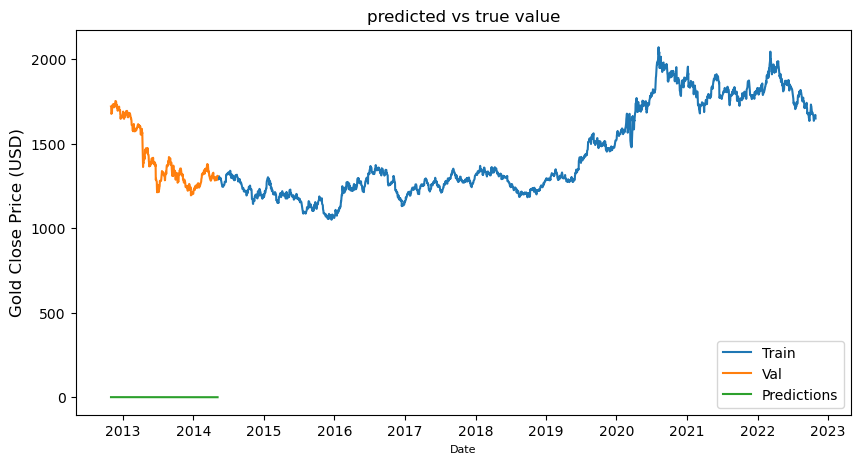

In [67]:
# Visualising the results
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('predicted vs true value')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Gold Close Price (USD)', fontsize=12)
plt.plot(train['Close/Last'])
plt.plot(valid[['Close/Last', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**As, we can observe the predicted price is close to the true price.**